# Can we predict whether an Arrest will be made for a commited crime?

## Imports

In [64]:
# Std lib:
import warnings
import os

# To hide environment variables:
from dotenv import load_dotenv

# Data manipulation:
import numpy as np
import pandas as pd
import geopandas
from shapely.geometry import Point, Polygon
from sklearn.utils import resample

# Feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Model build and procedure:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Model eval metrics and validation:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Visualization:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline
style.use('seaborn')

# Display all columns in Jupyter:
from IPython.display import display
pd.options.display.max_columns = None

# Display model:
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus
from sklearn.tree.export import export_text

# Filter Warnings
warnings.filterwarnings('ignore')

## Pull in the Data 

In [65]:
datatypes = {'block': 'object',
             'iucr': 'object',
             'primary_type': 'object',
             'description': 'object',
             'location_description': 'object',
             'arrest': 'bool',
             'domestic': 'bool',
             'beat': 'int64',
             'district': 'float64',
             'ward': 'float64',
             'community_area': 'int64',
             'fbi_code': 'object',
             'x_coordinate': 'float64',
             'y_coordinate': 'float64',
             'year': 'int64',
             'latitude': 'float64',
             'longitude': 'float64',
             'location': 'object',
             'month': 'uint8',
             'hour': 'uint8',
             'dayofweek': 'uint8',
             'weekend': 'bool',
             'CF': 'float64',
             'CF3': 'float64',
             'PI': 'float64',
             'EUH': 'float64',
             'CH': 'float64',
             'SOI': 'float64',
             'crime_code_category': 'category',
             'index_crime': 'bool',
             'violent_crime': 'bool',
             'property_crime': 'bool',
             'crime_against_persons': 'bool',
             'crime_against_property': 'bool',
             'crime_against_society': 'bool'}

In [66]:
load_dotenv()
path_to_data = os.environ.get('CLEAN_DATA')
df = pd.read_csv(path_to_data, dtype=datatypes)

In [67]:
# This is our full crime dataset from year 2002 - 2019
# About 6.5 million crime objects over 18 years, 37 attributes
df.shape

(6508416, 37)

In [68]:
# Check types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6508416 entries, 0 to 6508415
Data columns (total 37 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   date                    object  
 1   block                   object  
 2   iucr                    object  
 3   primary_type            object  
 4   description             object  
 5   location_description    object  
 6   arrest                  bool    
 7   domestic                bool    
 8   beat                    int64   
 9   district                float64 
 10  ward                    float64 
 11  community_area          int64   
 12  fbi_code                object  
 13  x_coordinate            float64 
 14  y_coordinate            float64 
 15  year                    int64   
 16  latitude                float64 
 17  longitude               float64 
 18  location                object  
 19  month                   uint8   
 20  hour                    uint8   
 21  dayofwee

# Predict the categorical class label of Arrest -> Classification Problem

In [69]:
# Check head of dataframe
df.head()

,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,latitude,longitude,location,month,hour,dayofweek,weekend,geometry,CF,CF3,PI,EUH,CH,SOI,crime_code_category,index_crime,violent_crime,property_crime,crime_against_persons,crime_against_property,crime_against_society
0,2007-02-12 16:30:24+00:00,022XX E 84TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,SIDEWALK,False,False,412,4.0,8.0,46,04A,1192780.0,1849721.0,2007,41.742602,-87.569225,"(41.742601793, -87.569224999)",2,16,0,False,POINT (-87.569224999 41.742601793),0.217799,0.149036,0.23225,-0.079545,-0.024929,0.090023,Aggravated Assault,True,True,False,True,False,False
1,2007-02-09 20:22:00+00:00,040XX W 57TH ST,0520,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,True,False,813,8.0,13.0,62,04A,1150365.0,1866496.0,2007,41.789564,-87.724200,"(41.789563573, -87.72419981)",2,20,4,False,POINT (-87.72419981 41.789563573),0.217799,0.149036,0.23225,-0.079545,-0.024929,0.090023,Aggravated Assault,True,True,False,True,False,False
2,2007-02-27 13:55:00+00:00,070XX S MAY ST,0520,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,STREET,True,False,733,7.0,17.0,68,04A,1169870.0,1858045.0,2007,41.765972,-87.652926,"(41.765971524, -87.652925956)",2,13,1,False,POINT (-87.652925956 41.765971524),0.217799,0.149036,0.23225,-0.079545,-0.024929,0.090023,Aggravated Assault,True,True,False,True,False,False
3,2007-02-13 08:58:52+00:00,086XX S BALTIMORE AVE,051A,ASSAULT,AGGRAVATED: HANDGUN,RESIDENCE,False,False,424,4.0,10.0,46,04A,1198297.0,1848271.0,2007,41.738487,-87.549059,"(41.738486677, -87.549059491)",2,8,1,False,POINT (-87.54905949099999 41.738486677),0.217799,0.149036,0.23225,-0.079545,-0.024929,0.090023,Aggravated Assault,True,True,False,True,False,False
4,2007-02-18 04:00:00+00:00,030XX S DR MARTIN LUTHER KING JR DR,0520,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,APARTMENT,False,True,2122,1.0,4.0,35,04A,1179408.0,1885031.0,2007,41.839811,-87.617142,"(41.83981113, -87.617141911)",2,4,6,True,POINT (-87.617141911 41.83981113),0.217799,0.149036,0.23225,-0.079545,-0.024929,0.090023,Aggravated Assault,True,True,False,True,False,False


## Choose Categorical Attributes for Model:

In [70]:
# Decide which categorical variables to use in models
for col_name in df.columns:
    if df[col_name].dtypes == 'object' or df[col_name].dtypes == 'bool' or df[col_name].dtypes == 'uint8' or df[col_name].dtypes == 'int64':
        unique_cat = len(df[col_name].unique())
        print("Attribute '{col_name}' has {unique_cat} unique categories".format(col_name = col_name, unique_cat = unique_cat))


Attribute 'date' has 2650316 unique categories
Attribute 'block' has 36071 unique categories
Attribute 'iucr' has 400 unique categories
Attribute 'primary_type' has 35 unique categories
Attribute 'description' has 528 unique categories
Attribute 'location_description' has 214 unique categories
Attribute 'arrest' has 2 unique categories
Attribute 'domestic' has 2 unique categories
Attribute 'beat' has 303 unique categories
Attribute 'community_area' has 78 unique categories
Attribute 'fbi_code' has 26 unique categories
Attribute 'year' has 20 unique categories
Attribute 'location' has 655101 unique categories
Attribute 'month' has 12 unique categories
Attribute 'hour' has 24 unique categories
Attribute 'dayofweek' has 7 unique categories
Attribute 'weekend' has 2 unique categories
Attribute 'geometry' has 655101 unique categories
Attribute 'index_crime' has 2 unique categories
Attribute 'violent_crime' has 2 unique categories
Attribute 'property_crime' has 2 unique categories
Attribute 

In [71]:
# About 27% of arrests return true
# There is a class imbalance that we have to deal with
df.groupby('arrest').size()

arrest
False    4746113
True     1762303
dtype: int64

In [72]:
# Make a dataframe copy that will be manipulated and used for models
df_work = df.copy()

<a id='home'></a>

## Pre-process data for Model:

In [73]:
# Data pre-processing -> ensure that categorical attributes used are converted appropriately
d={True:1,False:0}
df_work["domestic"] = df_work["domestic"].map(d)
df_work["weekend"] = df_work["weekend"].map(d) 
df_work["violent_crime"] = df_work["violent_crime"].map(d) 
df_work["property_crime"] = df_work["property_crime"].map(d) 
df_work["index_crime"] = df_work["index_crime"].map(d)
df_work["crime_against_persons"] = df_work["crime_against_persons"].map(d)
df_work["crime_against_property"] = df_work["crime_against_property"].map(d)
df_work["crime_against_society"] = df_work["crime_against_society"].map(d)
df_work["arrest"] = df_work["arrest"].map(d)

df_work.head()

,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,latitude,longitude,location,month,hour,dayofweek,weekend,geometry,CF,CF3,PI,EUH,CH,SOI,crime_code_category,index_crime,violent_crime,property_crime,crime_against_persons,crime_against_property,crime_against_society
0,2007-02-12 16:30:24+00:00,022XX E 84TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,SIDEWALK,0,0,412,4.0,8.0,46,04A,1192780.0,1849721.0,2007,41.742602,-87.569225,"(41.742601793, -87.569224999)",2,16,0,0,POINT (-87.569224999 41.742601793),0.217799,0.149036,0.23225,-0.079545,-0.024929,0.090023,Aggravated Assault,1,1,0,1,0,0
1,2007-02-09 20:22:00+00:00,040XX W 57TH ST,0520,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,1,0,813,8.0,13.0,62,04A,1150365.0,1866496.0,2007,41.789564,-87.724200,"(41.789563573, -87.72419981)",2,20,4,0,POINT (-87.72419981 41.789563573),0.217799,0.149036,0.23225,-0.079545,-0.024929,0.090023,Aggravated Assault,1,1,0,1,0,0
2,2007-02-27 13:55:00+00:00,070XX S MAY ST,0520,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,STREET,1,0,733,7.0,17.0,68,04A,1169870.0,1858045.0,2007,41.765972,-87.652926,"(41.765971524, -87.652925956)",2,13,1,0,POINT (-87.652925956 41.765971524),0.217799,0.149036,0.23225,-0.079545,-0.024929,0.090023,Aggravated Assault,1,1,0,1,0,0
3,2007-02-13 08:58:52+00:00,086XX S BALTIMORE AVE,051A,ASSAULT,AGGRAVATED: HANDGUN,RESIDENCE,0,0,424,4.0,10.0,46,04A,1198297.0,1848271.0,2007,41.738487,-87.549059,"(41.738486677, -87.549059491)",2,8,1,0,POINT (-87.54905949099999 41.738486677),0.217799,0.149036,0.23225,-0.079545,-0.024929,0.090023,Aggravated Assault,1,1,0,1,0,0
4,2007-02-18 04:00:00+00:00,030XX S DR MARTIN LUTHER KING JR DR,0520,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,APARTMENT,0,1,2122,1.0,4.0,35,04A,1179408.0,1885031.0,2007,41.839811,-87.617142,"(41.83981113, -87.617141911)",2,4,6,1,POINT (-87.617141911 41.83981113),0.217799,0.149036,0.23225,-0.079545,-0.024929,0.090023,Aggravated Assault,1,1,0,1,0,0


## Feature Selection:

In [74]:
# Possible attributes for our model
X = df_work[["domestic", "weekend", "violent_crime", "property_crime", "index_crime", 
             "crime_against_persons", "crime_against_property", "crime_against_society"]]

# Our class label
y = df_work.arrest

### Feature Importance =>

ExtraTreesClassifier is a randomized decision tree classifier which samples a random subset of the feature space and essentially helps decide where to make the next split. 

In [75]:
# Build the randomized DT for feature ranking
model = ExtraTreesClassifier()
model.fit(X, y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [76]:
# Score based on feature importance
print(model.feature_importances_)

[1.01134923e-01 2.96095553e-04 3.69718031e-03 3.36957064e-02
 4.02226184e-02 1.16609665e-01 1.96867463e-01 5.07476348e-01]


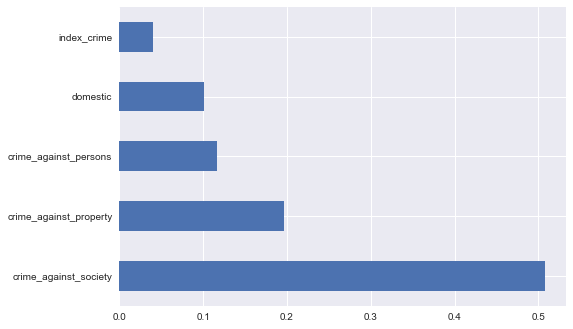

In [77]:
# Plot the 5 most important features
feat_importances = pd.Series(model.feature_importances_, index = X.columns)
feat_importances.nlargest(5).plot(kind = "barh")
plt.show()

I will use this result to select attributes for my Decision Tree model. 

### Univariate Selection =>

We can look at each feature individually. With SelectKBest, each feature's relative importance in predicting the output (true or false for arrest) is evaluated with statiscal tests.

In [78]:
# Use SelectKBest to extract top features
bestfeatures = SelectKBest(score_func = chi2, k = 5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [79]:
# Concat 2 dataframes for visualization
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Attributes', 'Score']  
featureScores

,Attributes,Score
0,domestic,2.539165e+04
1,weekend,4.377128e+02
2,violent_crime,2.388462e+04
3,property_crime,3.032655e+05
4,index_crime,3.130033e+05
5,crime_against_persons,1.757234e+04
6,crime_against_property,5.074632e+05
7,crime_against_society,1.388981e+06


In [80]:
# Look at the 5 best features
print(featureScores.nlargest(5, 'Score'))  

               Attributes         Score
7   crime_against_society  1.388981e+06
6  crime_against_property  5.074632e+05
4             index_crime  3.130033e+05
3          property_crime  3.032655e+05
0                domestic  2.539165e+04


We note a slight difference in individual attribute ranking here compared to using the ExtraTreesClassifier to rank attributes.

## Logistic Regression:

In [81]:
# Attributes for our model
X = df_work[["domestic", "index_crime", "property_crime", "crime_against_property", "crime_against_society"]]

# Our class label
y = df_work.arrest

In [82]:
# Split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

We could also use other methods to validate our data. I chose to split to train and test set. There is less overfitting than train/testing on the same data. Also, it runs much faster than k-fold cross validation.

In [83]:
# Train logistic regression model on training set
log_reg_model = LogisticRegression(class_weight = "balanced")
log_reg_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
# Make class prediction for testing set
y_pred = log_reg_model.predict(X_test)

### Model Evaluation =>

In [85]:
# Calculate accuracy for Logistic Regression Model
log_reg_score = accuracy_score(y_test, y_pred) * 100
print(str(round(log_reg_score,1)) + " %")

82.0 %


This is a very solid accuracy. Logistic Regression is great for binary classification; our arrest attribute has classes 0 or 1. It is also very efficient to train. It is crucial to set class_weight above to balanced since the arrest classes are imbalanced. It essentially replicates the smaller class until there are as many samples as in larger class. Without this, our accuracy would be inaccurate due to the bias.

In [86]:
# Calculate Precision (Exactness), Recall (Completeness) and F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88   1187245
           1       0.69      0.61      0.65    439859

    accuracy                           0.82   1627104
   macro avg       0.78      0.75      0.76   1627104
weighted avg       0.81      0.82      0.82   1627104



The precision and recall values are case sensitive measures gives more insight to our accuracy. Our precision and recall are close to 1.0 which is a great sign.

In [87]:
# See confusion matrix (orders from 0 to 1)
# TN  FP
# FN  TP
print(confusion_matrix(y_test, y_pred))

[[1068269  118976]
 [ 173472  266387]]


The two values we care most about in this confusion matrix is the True Positive and True Negative. It means that 1,334,656 are predicted correctly while only 292,448 are predicted incorrectly.

## Decision Tree (Entropy as Attribute Selection Measure) :

In [88]:
# Split into train and test set
# shuffle = False
train, test = train_test_split(df_work, test_size = 0.25, random_state = 0)

In [89]:
# Respective sizes of train and test set
print("Training set size: " + str(len(train)) + ", Test set size: " + str(len(test)))

Training set size: 4881312, Test set size: 1627104


In [90]:
# Use Entropy (Info Gain) as attribute selection measure for our Decision Tree
# min_samples_split -> Min number of samples required to split an attribute/node
# Too large -> underfitting 
# Too small -> overfitting is an issue (too specific on training data and not good prediction for test set)

c = DecisionTreeClassifier(criterion = "entropy", min_samples_split = 100, class_weight = "balanced")

# Possible hyperparameter tuning ->
# max_depth = 10
# min_samples_leaf = 50

We know that Entropy is an attribute selection measure for decision tree. Based on information gain, It helps us decide which attribute to split on first. 

In [91]:
# Attributes for our model
attributes = ["domestic", "index_crime", "crime_against_persons", "crime_against_property", "crime_against_society"]

# Our class label
the_class = "arrest"

In [92]:
# For training
x_train = train[attributes]
y_train = train[the_class]

# For testing
x_test = test[attributes]
y_test = test[the_class]

In [93]:
# Train DT model on training set
dt_model = c.fit(x_train, y_train)

### Display Decision Tree =>

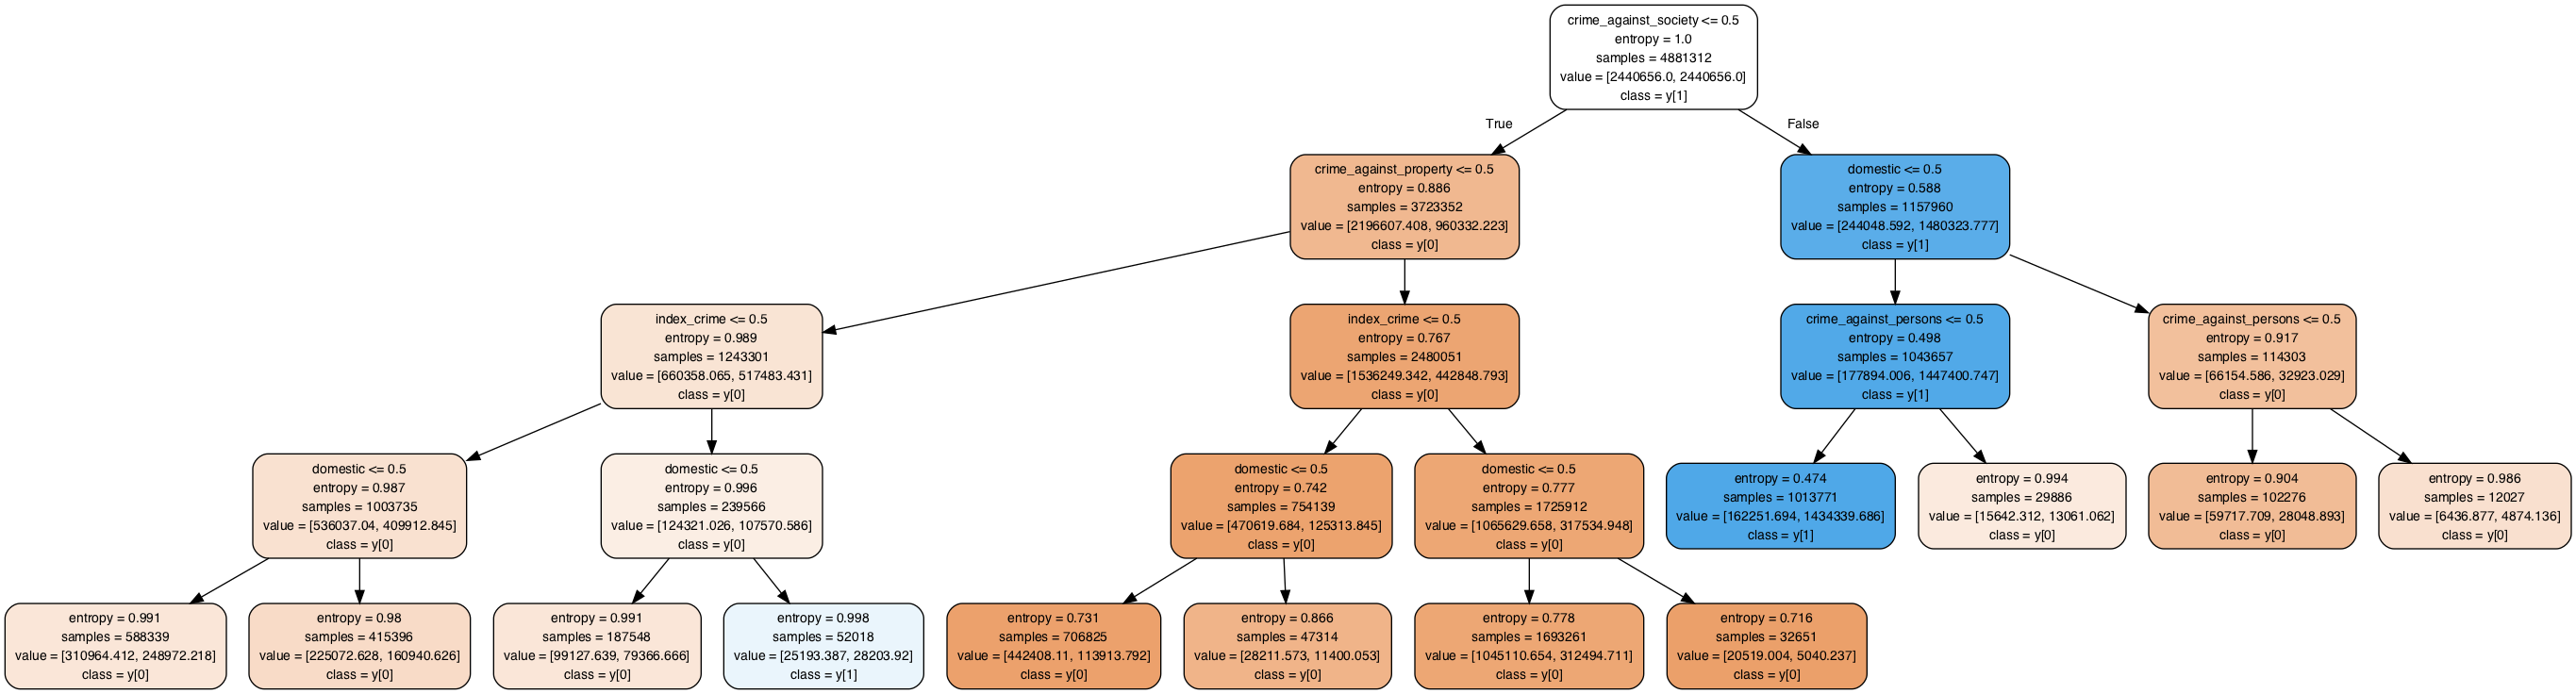

In [94]:
# Text I/O implementation 
dot_data = StringIO()

# Export a decision tree in DOT format
# Generate a GraphViz representation of the decision tree and write into out_file
tree.export_graphviz(dt_model, out_file = dot_data, feature_names = attributes, filled = True, rounded = True, class_names = True)

# Load graph as defined by data in DOT format
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Create image object
Image(graph.create_png())

We can see which attributes are split on first based on the entropy in our decision tree. The paths of our decision tree gives us many rules. We can also see the number of samples and class that is predicted traversing down a path.

In [95]:
# Decision tree is intuitive to interpret 
r = export_text(dt_model, feature_names = attributes)
print(r)

|--- crime_against_society <= 0.50
|   |--- crime_against_property <= 0.50
|   |   |--- index_crime <= 0.50
|   |   |   |--- domestic <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- domestic >  0.50
|   |   |   |   |--- class: 0
|   |   |--- index_crime >  0.50
|   |   |   |--- domestic <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- domestic >  0.50
|   |   |   |   |--- class: 1
|   |--- crime_against_property >  0.50
|   |   |--- index_crime <= 0.50
|   |   |   |--- domestic <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- domestic >  0.50
|   |   |   |   |--- class: 0
|   |   |--- index_crime >  0.50
|   |   |   |--- domestic <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- domestic >  0.50
|   |   |   |   |--- class: 0
|--- crime_against_society >  0.50
|   |--- domestic <= 0.50
|   |   |--- crime_against_persons <= 0.50
|   |   |   |--- class: 1
|   |   |--- crime_against_persons >  0.50
|   |   |   |--- class: 0
|   |--- domestic >  0.50
|   |   |--- cri

An alternative way to visualize a decision tree.

In [96]:
# Make class prediction for test set
y_predict = c.predict(x_test)
print(y_predict)

[0 0 0 ... 1 1 0]


### Model Evaluation =>

In [97]:
# Calculate accuracy for Decision Tree (Entropy)
dt_score = accuracy_score(y_test, y_predict) * 100
print(str(round(dt_score,1)) + " %")

83.5 %


This is a fantastic accuracy! I used ExtraTreesClassifier for feature importance ranking as seen above. This guided my selection of features to feed into my decision tree model. This has further improved the accuracy of my decision tree model.

In [98]:
# Calculate Precision (Exactness), Recall (Completeness) and F1-score
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89   1187245
           1       0.74      0.60      0.66    439859

    accuracy                           0.84   1627104
   macro avg       0.80      0.76      0.78   1627104
weighted avg       0.83      0.84      0.83   1627104



The precision and recall values are case sensitive measures gives more insight to our accuracy. Our precision and recall are leaning towards 1.0 which is great.

In [99]:
# See confusion matrix (orders from 0 to 1)
# TN  FP
# FN  TP
print(confusion_matrix(y_test, y_predict))

[[1095802   91443]
 [ 176469  263390]]


The values we care most about in this confusion matrix are the True Positive and True Negative. It means that 1,359,192 are predicted correctly while only 267,912 are predicted incorrectly. This is an improvement from our logistic regression model!

## Decision Tree (Gini as Attribute Selection Measure) :

In [100]:
# Use Gini (Gini Impurity) as attribute selection measure for our Decision Tree
c2 = DecisionTreeClassifier(criterion = "gini", min_samples_split = 100, class_weight= "balanced")

We know that Gini Index is an attribute selection measure for decision tree. Based on gini impurity, It helps us decide which attribute to split on first. 

In [101]:
# For training
x_train = train[attributes]
y_train = train[the_class]

# For testing
x_test = test[attributes]
y_test = test[the_class]

In [102]:
# Train DT model on training set
dt_model2 = c2.fit(x_train, y_train)

### Display Decision Tree =>

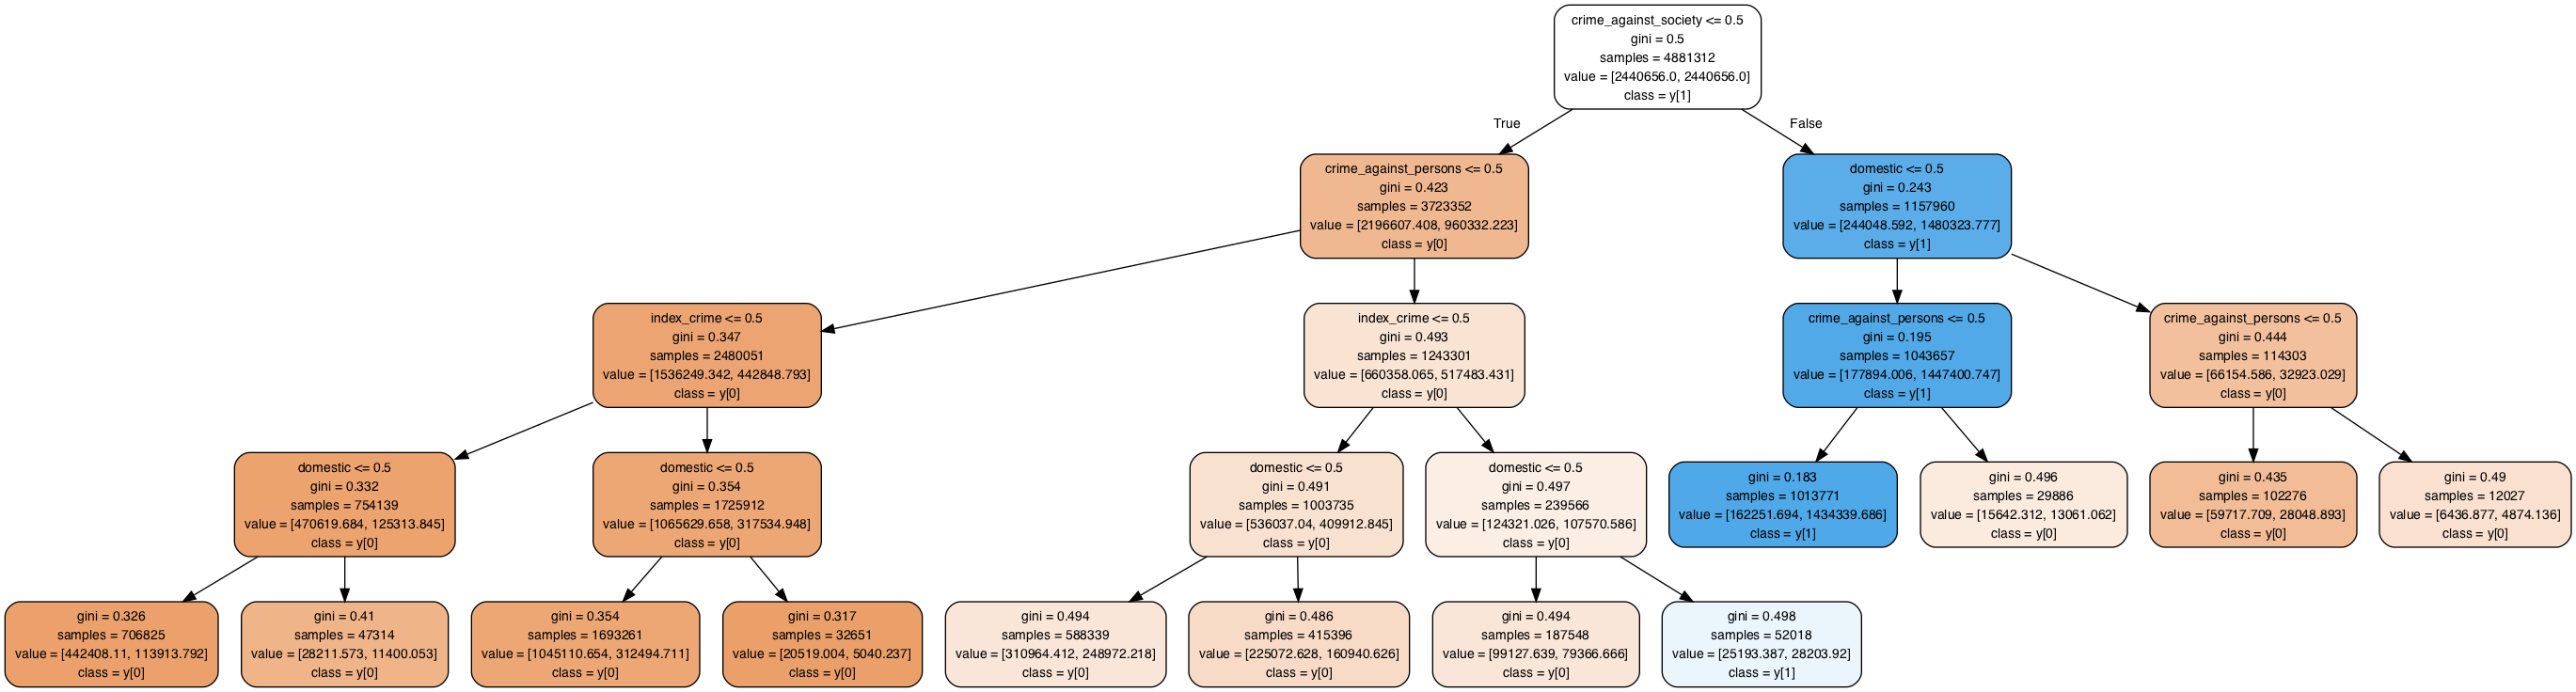

In [103]:
# Text I/O implementation 
dot_data = StringIO()

# Export a decision tree in DOT format
# Generate a GraphViz representation of the decision tree and write into out_file
tree.export_graphviz(dt_model2, out_file = dot_data, feature_names = attributes, filled = True, rounded = True, class_names = True)

# Load graph as defined by data in DOT format
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Create image object
Image(graph.create_png())

We can see which attributes are split on first based on the gini impurity in our decision tree. The paths of our decision tree gives us many rules. We can also see the number of samples and class that is predicted traversing down a path.

In [104]:
# Decision tree is intuitive to interpret 
r2 = export_text(dt_model2, feature_names = attributes)
print(r2)

|--- crime_against_society <= 0.50
|   |--- crime_against_persons <= 0.50
|   |   |--- index_crime <= 0.50
|   |   |   |--- domestic <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- domestic >  0.50
|   |   |   |   |--- class: 0
|   |   |--- index_crime >  0.50
|   |   |   |--- domestic <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- domestic >  0.50
|   |   |   |   |--- class: 0
|   |--- crime_against_persons >  0.50
|   |   |--- index_crime <= 0.50
|   |   |   |--- domestic <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- domestic >  0.50
|   |   |   |   |--- class: 0
|   |   |--- index_crime >  0.50
|   |   |   |--- domestic <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- domestic >  0.50
|   |   |   |   |--- class: 1
|--- crime_against_society >  0.50
|   |--- domestic <= 0.50
|   |   |--- crime_against_persons <= 0.50
|   |   |   |--- class: 1
|   |   |--- crime_against_persons >  0.50
|   |   |   |--- class: 0
|   |--- domestic >  0.50
|   |   |--- crime

An alternative way to visualize a decision tree.

In [105]:
# Make class prediction for test set
y_predict = c2.predict(x_test)
print(y_predict)

[0 0 0 ... 1 1 0]


### Model Evaluation =>

In [106]:
# Calculate accuracy for Decision Tree (Gini)
dt_score2 = accuracy_score(y_test, y_predict) * 100
print(str(round(dt_score2,1)) + " %")

83.5 %


The accuracy remained the same with the Gini attribute selection measure.

In [107]:
# Calculate Precision (Exactness), Recall (Completeness) and F1-score
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89   1187245
           1       0.74      0.60      0.66    439859

    accuracy                           0.84   1627104
   macro avg       0.80      0.76      0.78   1627104
weighted avg       0.83      0.84      0.83   1627104



There is no noticeable difference in the classification report with the Gini attribute selection measure.

In [108]:
# See confusion matrix (orders from 0 to 1)
# TN  FP
# FN  TP
print(confusion_matrix(y_test, y_predict))

[[1095802   91443]
 [ 176469  263390]]


The confusion matrix also remained the same which means that the classifications are the same for the test set.

### Attribute Selection Measure Comparison for DT (Entropy vs. Gini) =>

Entropy for attribute selection is slower to compute due to logarithmic functions but overall, the two attribute selection measures did not make much difference as seen in the evaluation metrics.

## K-Nearest Neighbor:

In [109]:
# Can change number of objects to model
# 1,000,000 objects -> downsampled to 258,212 objects -> 67.6% KNN accuracy
df_smaller = df.head(1000000) 
df_smaller.groupby('arrest').size()

arrest
False    870894
True     129106
dtype: int64

I created a smaller dataframe for performing K-Nearest Neighbor since it is very slow compared to the other models. We cannot use the same dataset size.

### Down-Sampling to Balance Arrest Classes =>

In [110]:
# Arrest class label is quite imbalanced (ie. a lot more 0s than 1s -> Most arrests are false)
# Let's down sample the majority class (We could also up sample minority class but KNN is slow)

# Separate majority and minority classes
df_majority = df_smaller[df_smaller.arrest == 0]
df_minority = df_smaller[df_smaller.arrest == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace = False,      # sample without replacement
                                 n_samples = 129106,   # set to match minority class
                                 random_state = 0)     

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new arrest class counts
df_downsampled.arrest.value_counts()

True     129106
False    129106
Name: arrest, dtype: int64

I down-sampled the 0 class for arrest to resolve the class imbalance issue and for more reliable results. I could also up-sample the 1 class but the dataset itself is already very big so down-sampling is a better option.

In [111]:
# Down sampled dataframe for KNN model
df_downsampled.shape

(258212, 37)

The updated number of objects that will be inputted into our KNN model.

In [112]:
# Attributes for our model
a = df_downsampled[["domestic", "index_crime", "property_crime", "crime_against_property", "crime_against_society"]]

# Our class label
b = df_downsampled.arrest

In [113]:
# Split to train and test set
X_train, X_test, y_train, y_test = train_test_split(a, b, test_size = 0.25, random_state = 0)

In [114]:
# Scale features so they are uniformly evaluated
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [115]:
# Choosing n_neighbors with sqrt(n) where n is number of objects
# There are other ways to choose n_neighbors (ie. K for KNN)
classifier = KNeighborsClassifier(n_neighbors = 508) 
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=508, p=2,
                     weights='uniform')

In [116]:
# Make class prediction for testing set
y_predd = classifier.predict(X_test)

### Model Evaluation =>

In [117]:
# Calculate accuracy for KNN Model
scoree = accuracy_score(y_test, y_predd) * 100
print(str(round(scoree,1)) + " %")

67.6 %


We can see that the accuracy for KNN is not as good as the other models. However, if we increase the data that is fed into our KNN model, our accuracy would improve a little more. With some experimentation with different data sizes and observing the improvement rate, it is appaarent that KNN is not the best model for predicting arrest even if we increase data size.

In [118]:
# Calculate Precision (Exactness), Recall (Completeness) and F1-score
print(classification_report(y_test, y_predd))

              precision    recall  f1-score   support

       False       0.71      0.60      0.65     32245
        True       0.65      0.75      0.70     32308

    accuracy                           0.68     64553
   macro avg       0.68      0.68      0.67     64553
weighted avg       0.68      0.68      0.67     64553



The precision and recall is also farther to 1.0 when compared to our other models. This is not a good sign for this model.

In [119]:
# See confusion matrix (orders from 0 to 1)
# TN  FP
# FN  TP
print(confusion_matrix(y_test, y_predd))

[[19452 12793]
 [ 8095 24213]]


The confusion matrix also indicates that the False Positive and False Negatives are relatively high.

## Naive Bayes:

In [120]:
# Attributes for our model
X2 = df_work[["domestic", "index_crime", "crime_against_persons", "crime_against_property", "crime_against_society"]]

# Our class label
y2 = df_work.arrest

In [121]:
# Split to train and test set
# Less overfitting than train/test on same data and runs much faster than k-fold cross validation
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.25, random_state = 0)

In [122]:
# Train Naive Bayes model on training set
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [123]:
# Make class prediction for testing set
y_pred = nb_model.predict(X_test)

### Model Evaluation =>

In [124]:
# Calculate accuracy for Naive Bayes Model
nb_score = accuracy_score(y_test, y_pred) * 100
print(str(round(nb_score,1)) + " %")

82.0 %


This is a very good accuracy. Naive Bayes is based on Baye's Theorem and predicts class membership probabilities. With prior and posterior probabilities, it calculates if the 0 or 1 class for arrest is more probable. Since the result is good, we can also assume that there is not much dependence between the attributes. (Assumption for Naive Bayes)

In [125]:
# Calculate Precision (Exactness), Recall (Completeness) and F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88   1187245
           1       0.69      0.61      0.65    439859

    accuracy                           0.82   1627104
   macro avg       0.78      0.75      0.76   1627104
weighted avg       0.81      0.82      0.82   1627104



The precision and recall values are case sensitive measures gives more insight to our accuracy. Our precision and recall are close to 1.0. Great!

In [126]:
# See confusion matrix (orders from 0 to 1)
# TN  FP
# FN  TP
print(confusion_matrix(y_test, y_pred))

[[1068269  118976]
 [ 173472  266387]]


The two values we care most about in this confusion matrix is the True Positive and True Negative. It means that 1,334,656 are predicted correctly while only 292,448 (False Postive and False Negatives) are predicted incorrectly. This is a really good ratio!

## Results & Model Comparison:

To find the best classification model to predict whether an arrest is made, I implemented Logistic Regression, Decision Trees (Entropy vs Gini as attribute selection measures), K-Nearest Neighbor and Naive Bayes. To quantify the performence of the different models, I utilized evalution metrics including accuracy (with a portion of our data used for the test set, we can analyze how accurate our models predict them), precision, recall, F-1 score, support and by displaying the confusion matrix. The confusion matrix allows us to break down the evaluation measures in even more detail and compare the models with True Positive, True Negative, False Positive and False Negative counts for arrests. 

In order to further improve my model accuracy and other evaluation measures, I used two methods for feature selection. I plotted the 5 most important features using a randomized decision tree classifier (ExtraTreesClassifier) which samples a random subset of the feature space to give feature priority. I then used univariate selection to look at each feature individually. With SelectKBest, each feature's relative importance in predicting the output (true or false for arrest) is ranked. I used the ExtraTreesClassifier to select features for my decision tree models. I took univariate selection into account for the building of my other classification models.

In terms of model comparison, the decision tree model gave the highest accuracy out of all of the models with 83.5% followed by Naive Bayes and Logistic Regression models at 82%. These 3 classification models are all relatively decent for predicting arrest based on selected attributes. KNN can be improved with increasing input data to the model but performs the worst in this case. We know that the decision tree model is great for interpreting classification decisions. The tree structure is extremely intuitive and easy to traverse until we reach a prediction class. As we can see from our decision tree above, the classes give 1 or 0 for arrest and not arrested respectively. The Naive Bayes model supports incremental data and runs extremely fast in comparison to the other models I tested. The KNN model is great for smaller dataset but not for this large crime dataset. Since KNN is lazy learning, it doesn't generalize our data in advance and only starts learning when new instances need classifying.